Import libraries

In [1]:
from Perturbation import *
from Leave_one_feature_out import *
from Sequential_feature_selection import *
from Cross_validation.KFold import *
from Cross_validation.TimeSeriesSplit import *
from sklearn.datasets import *
from Plots.Prediction_plots import *
from Cross_validation.TimeSeriesData import *
Plots = Prediction_plots()
converter = Covert_to_Time_Series()

Create train and test sets

In [2]:
zbior = load_breast_cancer()
data = pd.DataFrame(zbior.data, columns= zbior.feature_names)
data['target'] = pd.Series(zbior.target)
X = data.drop('target', axis=1).values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

Perturabtion

Feature ranking: [ 9  6  9  9  9  9  9  9  9  9  9  9  5  4 10  9  8  9  9  9  9 11  9  1
  3  9  9  2  9  7]


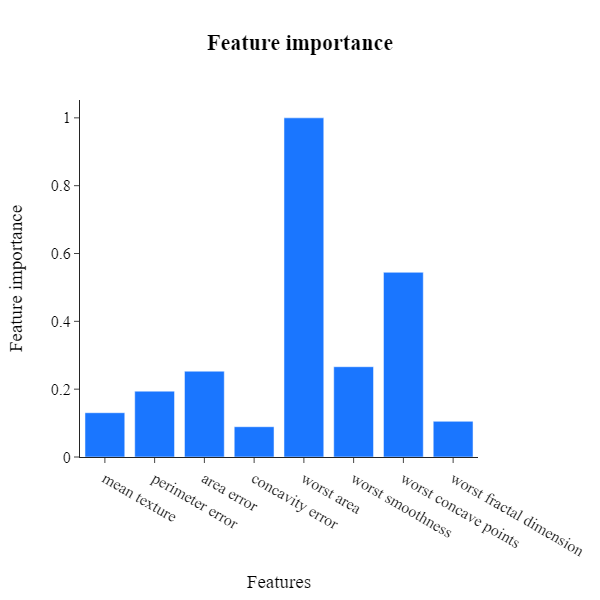

In [3]:
model = DecisionTreeClassifier(random_state=17)
perturbacja = Perturabtion(algorithm=model, metric="roc_auc", n_repeats=10)
perturbacja.fit(X_train, y_train)
print("Feature ranking: {}".format(perturbacja.ranking_))
Plots.plot_feature_importances(feature_importances=perturbacja.feature_importances_, column_names=list(data.drop("target", axis=1).columns), nlargest=8)

We can also check how our feature importance plot looks like without scaling the data. So in other words how muuch our roc_auc score decrease after perturbating selected feature.

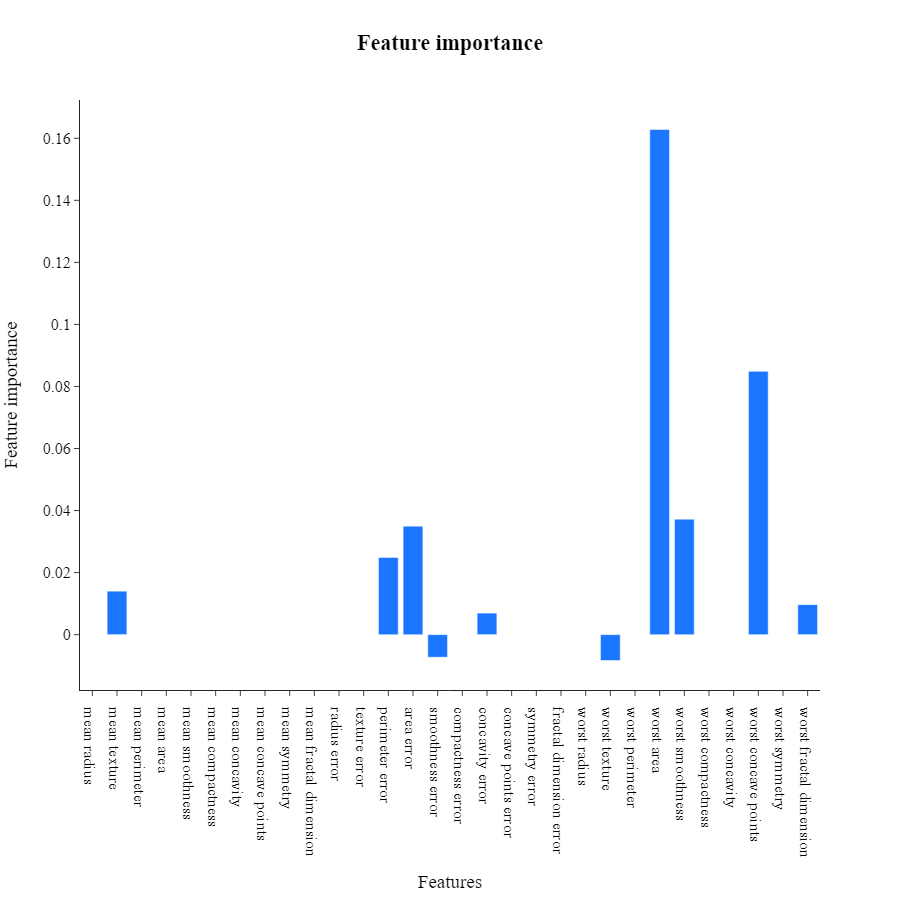

In [4]:
Plots.plot_feature_importances(feature_importances=perturbacja.unscaled_feature_importances_, column_names=list(data.drop("target", axis=1).columns))

To verify that our perturbation technique works, we will create additional dataset with 10 features. 

In this dataset our target is dependent from variable at index 3 and 8, because in:

- classification:  x3*x8<median(x3*x8) => 1 else 0.

- regression: y = 0.5*x3+0.5*x8

Therefore our plot should simply return that features 3 and 8 are the most important.

In [5]:
def create_data(problem_type):
    x = np.random.uniform(0, 10, size=(1000, 10))
    if(problem_type=="classification"):
        return x, np.where(x[:,3]*x[:,8] < np.quantile(x[:,0]*x[:,1], q=0.5), 1, 0)
    else:
        return x, 0.5*x[:, 3]+0.5*x[:, 8]
X, y = create_data("classification")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

Feature ranking: [4 5 3 2 5 5 5 5 1 5]


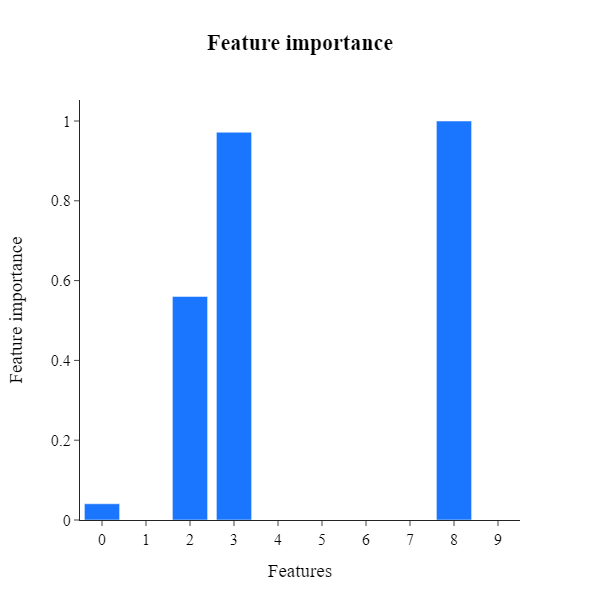

In [6]:
model = DecisionTreeClassifier(random_state=17)
perturbacja = Perturabtion(algorithm=model, metric="roc_auc", n_repeats=10)
perturbacja.fit(X_train, y_train)
print("Feature ranking: {}".format(perturbacja.ranking_))
Plots.plot_feature_importances(feature_importances=perturbacja.feature_importances_)

As we can see from above chart our Perturbation method works fine

Now let's check regression

Feature ranking: [ 5  6  3  1  9  4  8  7  2 10]


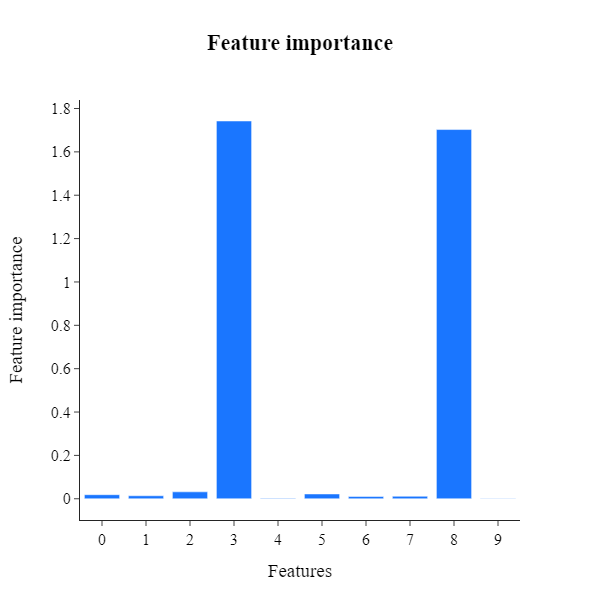

In [7]:
X, y = create_data("regression")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)
model = DecisionTreeRegressor(random_state=17)
lofo = Leave_One_Feature_Out(algorithm=model, metric="neg_rmse")
lofo.fit(X_train, y_train, X_valid=X_valid, y_valid=y_valid)
print("Feature ranking: {}".format(lofo.ranking_))
Plots.plot_feature_importances(feature_importances=lofo.unscaled_feature_importances_)

I also made Perturbation class compatible with pytorch LSTM

In [8]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, problem_type):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.problem_type = problem_type
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def predict(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        #hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        hn = hn[-1,:,:].view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        if(self.problem_type=="classification"):
           out = torch.sigmoid(out)
        return out

class LSTM_model():
  def __init__(self, problem_type, random_state=17, metric="mse"):
    self.problem_type = problem_type
    self.random_state = random_state
    random.seed(random_state)
    metrics = {"binary_crossentropy": nn.BCELoss(),
                     "crossentropy": nn.CrossEntropyLoss(),
                     "hinge": nn.HingeEmbeddingLoss(),
                     "mse": torch.nn.MSELoss(),
                     "rmse": RMSELoss(),
                     "mae": torch.nn.L1Loss(),
                     "neg_mse": torch.nn.MSELoss(),
                     "neg_rmse": RMSELoss(),
                     "neg_mae": torch.nn.L1Loss()}
    if metric not in metrics:
        raise ValueError('Unsupported metric: {}'.format(metric))
    self.metric = metric
    self.eval_metric = metrics[metric]
    self.metric_type = metrics[metric]
 
  def fit(self, X, y, epochs=200, learning_rate=0.01, X_valid=None, y_valid=None, verbose=True):
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.verbose = verbose
    if(X_valid != None and y_valid != None):
      self.X_train = X
      self.y_train = y
      self.X_valid = X_valid
      self.y_valid = y_valid
    else:
      self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=0.2, random_state=self.random_state)
    self.model = LSTM(num_classes=self.y_train.shape[1], input_size = self.X_train.shape[2], hidden_size=16, num_layers=1, problem_type=self.problem_type) 
    self.load_best_valid_model_ = LSTM(num_classes=self.y_train.shape[1], input_size = self.X_train.shape[2], hidden_size=16, num_layers=1, problem_type=self.problem_type) 
    loss_fn = self.eval_metric
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    self.train_losses = []
    self.valid_losses = []
    best_valid_loss = np.inf
    for epoch in range(self.epochs):
      self.X_train.requires_grad = True
      self.X_train.grad = None
      self.model.zero_grad()
      outputs = self.model.predict(self.X_train)
      train_loss = loss_fn(outputs, self.y_train)
      self.train_losses.append(train_loss.item())
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      with torch.no_grad():
        self.model.eval()
        valid_preds = self.model.predict(self.X_valid)
        valid_loss = loss_fn(valid_preds, self.y_valid)
        self.valid_losses.append(valid_loss.item())
        if(valid_loss < best_valid_loss):
          best_valid_loss = valid_loss
          torch.save(self.model.state_dict(), 'saved_models/temp_best_model.pth')
          self.load_best_valid_model_.load_state_dict(torch.load('saved_models/temp_best_model.pth'))
      if(epoch%10 == 0 and self.verbose == True):
        print("EPOCH: {}: Train loss: {}; Valid loss: {}; Current best valid loss: {}".format(epoch, train_loss, valid_loss, best_valid_loss))
    self.X_train.grad = None
    output = self.model.predict(self.X_train)
    loss = loss_fn(self.y_train, output)
    optimizer.zero_grad()
    loss.backward()
    return self.X_train.grad

  def predict(self, X):
    if(self.problem_type == "classification"):
      return (self.model.predict(X) > 0.5).float().detach().squeeze(1)
    else:
       return self.model.predict(X).detach().squeeze(1)
    
  def predict_proba(self, X):
     return torch.cat((1-self.model.predict(X), self.model.predict(X)), dim=1).detach().squeeze(1)

EPOCH: 0: Train loss: 29.491483688354492; Valid loss: 27.907258987426758; Current best valid loss: 27.907258987426758
EPOCH: 10: Train loss: 7.989513874053955; Valid loss: 7.520524024963379; Current best valid loss: 4.868924140930176
EPOCH: 20: Train loss: 4.636648654937744; Valid loss: 4.8545098304748535; Current best valid loss: 4.247497081756592
EPOCH: 30: Train loss: 2.3994765281677246; Valid loss: 2.5306622982025146; Current best valid loss: 2.5306622982025146
EPOCH: 40: Train loss: 1.433180570602417; Valid loss: 1.3882207870483398; Current best valid loss: 1.3882207870483398
EPOCH: 50: Train loss: 0.814488410949707; Valid loss: 0.7206873297691345; Current best valid loss: 0.7206873297691345
EPOCH: 60: Train loss: 0.549662709236145; Valid loss: 0.4955275356769562; Current best valid loss: 0.4955275356769562
EPOCH: 70: Train loss: 0.4082515835762024; Valid loss: 0.4043002724647522; Current best valid loss: 0.4043002724647522
EPOCH: 80: Train loss: 0.3304235637187958; Valid loss: 0.

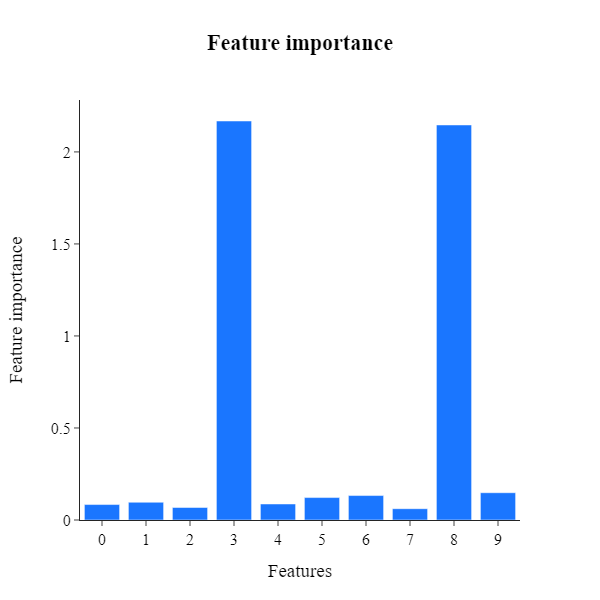

In [9]:
lstm = LSTM_model(problem_type="regression", random_state=17, metric="mse")
X_lstm, y_lstm = converter.create_lstm_data_torch(X_train, y_train, seq_length=3)
y_lstm = y_lstm.reshape(-1, 1)
perturbacja = Perturabtion(algorithm=lstm, metric="neg_rmse", n_repeats=10)
perturbacja.fit(X_lstm, y_lstm)
print("Feature ranking: {}".format(perturbacja.ranking_))
Plots.plot_feature_importances(feature_importances=perturbacja.unscaled_feature_importances_)

Leave One Feature Out

Feature ranking: [ 4  6  3  2  8 10  5  9  1  7]


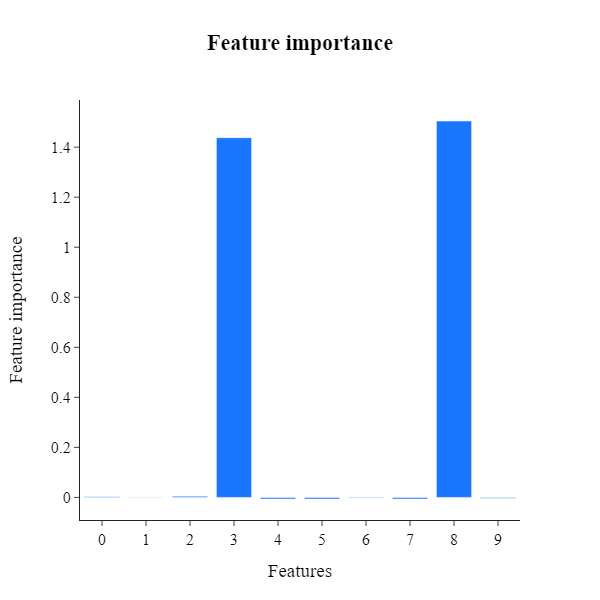

In [10]:
X, y = create_data("regression")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)
model = DecisionTreeRegressor(random_state=17)
perturbacja = Perturabtion(algorithm=model, metric="neg_rmse", n_repeats=10)
perturbacja.fit(X_train, y_train)
print("Feature ranking: {}".format(perturbacja.ranking_))
Plots.plot_feature_importances(feature_importances=perturbacja.unscaled_feature_importances_)

Forward Feature Selection

In [11]:
sfs = Sequential_feature_selection(algorithm=DecisionTreeRegressor(random_state=17), metric="neg_mse", cv=KFold(n_splits=5, shuffle=True, stratify=True))
sfs.forward_fit(X_train, y_train)
print("List of best features indexes: {}".format(sfs.list_of_best_variables_indexes))
print("Check support: {}".format(sfs.support_))
#Transform our train and test set that it will only contains selected features
print("Before change X_train shape: {}".format(X_train.shape))
X_train_transformed = sfs.transform(X_train)
X_test_transformed = sfs.transform(X_test)
print("After change X_train shape: {}".format(X_train_transformed.shape))

List of best features indexes: [8, 3]
Check support: [False False False  True False False False False  True False]
Before change X_train shape: (800, 10)
After change X_train shape: (800, 2)


It will work also for LSTM and classification dataset

In [12]:
X, y = create_data("classification")
X_lstm, y_lstm = converter.create_lstm_data_torch(X, y, seq_length=7)
y_lstm = y_lstm.reshape(-1, 1)
lstm = LSTM_model(problem_type="classification", random_state=17, metric="binary_crossentropy")
sfs = Sequential_feature_selection(algorithm=lstm, metric="roc_auc", cv=Time_Series(n_splits=3))
sfs.forward_fit_lstm(X_lstm, y_lstm)
print("List of best features indexes: {}".format(sfs.list_of_best_variables_indexes))
print("Check support: {}".format(sfs.support_))
#Transform our train and test set that it will only contains selected features
print("Before change X_train shape: {}".format(X_train.shape))
X_train_transformed = sfs.transform(X_train)
X_test_transformed = sfs.transform(X_test)
print("After change X_train shape: {}".format(X_train_transformed.shape))

EPOCH: 0: Train loss: 0.6928515434265137; Valid loss: 0.7290291786193848; Current best valid loss: 0.7290291786193848
EPOCH: 10: Train loss: 0.6894409656524658; Valid loss: 0.7196053862571716; Current best valid loss: 0.7018844485282898
EPOCH: 20: Train loss: 0.681939423084259; Valid loss: 0.727385938167572; Current best valid loss: 0.7018844485282898
EPOCH: 30: Train loss: 0.6606165766716003; Valid loss: 0.7720239162445068; Current best valid loss: 0.7018844485282898
EPOCH: 40: Train loss: 0.619861900806427; Valid loss: 0.9235769510269165; Current best valid loss: 0.7018844485282898
EPOCH: 50: Train loss: 0.5677599906921387; Valid loss: 1.0494365692138672; Current best valid loss: 0.7018844485282898
EPOCH: 60: Train loss: 0.504264235496521; Valid loss: 1.1429991722106934; Current best valid loss: 0.7018844485282898
EPOCH: 70: Train loss: 0.4557514488697052; Valid loss: 1.214526653289795; Current best valid loss: 0.7018844485282898
EPOCH: 80: Train loss: 0.3894786536693573; Valid loss:

Backward Feature selection

In [13]:
X, y = create_data("classification")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)
sfs = Sequential_feature_selection(algorithm=DecisionTreeClassifier(random_state=17), metric="accuracy")
sfs.backward_fit(X_train, y_train)
print("List of best features indexes: {}".format(sfs.list_of_best_variables_indexes))
print("Check support: {}".format(sfs.support_))
#Transform our train and test set that it will only contains selected features
print("Before change X_train shape: {}".format(X_train.shape))
X_train_transformed = sfs.transform(X_train)
X_test_transformed = sfs.transform(X_test)
print("After change X_train shape: {}".format(X_train_transformed.shape))

List of best features indexes: [3 6 8]
Check support: [False, False, False, True, False, False, True, False, True, False]
Before change X_train shape: (800, 10)
After change X_train shape: (800, 3)


Gradient

Simple linear algorithm

In [14]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out
    
def fit(model, X, y, criterion, epochs=500):
    X.requires_grad = True
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    for epoch in range(epochs):
        X.grad = None
        model.zero_grad()
        output = model(X)
        for layer in model.children():
            w = layer.state_dict()['weight']
            b = layer.state_dict()['bias']
            #print("W: {}".format(layer.state_dict()['weight']))
            #print("b: {}".format(layer.state_dict()['bias']))
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch%100==0):
            print("Epoch {}: Loss: {}".format(epoch, loss))
    #At the end of the algorithm training we will have to calculate gradients once again, because during the last epoch our weights were updated (by optimizer.step()). Therefore we have new values for weights (w) and bias (b) but ole one for X.grad.
    X.grad = None
    output = model(X)
    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    print("Final w: {}".format(w))
    print("Final b: {}".format(b))
    print("Input grad: {}".format(X.grad))
    print("Final output: {}".format(model(X)))
    return w.squeeze(), b.squeeze()

In [15]:
X = torch.tensor([[1.0, 2.0, 5.0], [4.0, 8.0, 9.0], [5.0, 2.0, 1.0], [3.0, 7.0, 4.0], [7.0, 5.0, 2.0]], requires_grad=True)
y = torch.tensor([[3.0], [12.0], [7.0], [10.0], [12.0]])

Belowe we will obtain weights and bias for MSE and MAE separately. It will be used to calculate gradient of loss function by hand.

MSE

In [16]:
model = LinearModel(input_size = X.shape[1], output_size = y.shape[1])
criterion = nn.MSELoss()
w_mse, b_mse = fit(model=model, X=X, y=y, criterion=criterion, epochs=500)

Epoch 0: Loss: 150.2244110107422
Epoch 100: Loss: 0.20810911059379578
Epoch 200: Loss: 0.004490206483751535
Epoch 300: Loss: 0.0003623750526458025
Epoch 400: Loss: 0.00010130244481842965
Final w: tensor([[1.0028, 0.9990, 0.0021]])
Final b: tensor([-0.0166])
Input grad: tensor([[-2.0394e-03, -2.0315e-03, -4.3514e-06],
        [ 2.3554e-03,  2.3463e-03,  5.0256e-06],
        [-9.2080e-04, -9.1726e-04, -1.9647e-06],
        [-2.6652e-03, -2.6550e-03, -5.6868e-06],
        [ 9.8698e-04,  9.8319e-04,  2.1059e-06]])
Final output: tensor([[ 2.9949],
        [12.0059],
        [ 6.9977],
        [ 9.9934],
        [12.0025]], grad_fn=<AddmmBackward0>)


In [17]:
def mse_backward_wrt_input(X,y,w,b):
    return -2/X.shape[0]*w*(y.reshape(1,-1)-X@w-b).reshape(-1,1)
print(mse_backward_wrt_input(X=X, y=y, w=w_mse, b=b_mse))

tensor([[-2.0394e-03, -2.0316e-03, -4.3515e-06],
        [ 2.3555e-03,  2.3465e-03,  5.0260e-06],
        [-9.2084e-04, -9.1730e-04, -1.9648e-06],
        [-2.6651e-03, -2.6548e-03, -5.6865e-06],
        [ 9.8714e-04,  9.8335e-04,  2.1063e-06]], grad_fn=<MulBackward0>)


Simple MSE

In [18]:
i = 0
gradient_matrix = np.zeros((X.shape[0], X.shape[1]))
while(i < X.shape[0]):
    j = 0
    grad = 0
    multiply_weights = 0
    while(j < X.shape[1]):
        multiply_weights = multiply_weights + X[i][j]*w_mse[j]
        j = j + 1
    middle = y[i]-multiply_weights-b_mse
    j = 0
    while(j < X.shape[1]):
        gradient_matrix[i][j] = -2/X.shape[0]*w_mse[j]*(middle)
        j = j + 1
    i = i + 1
print(gradient_matrix)

[[-2.03941809e-03 -2.03157659e-03 -4.35149605e-06]
 [ 2.35552993e-03  2.34647328e-03  5.02598232e-06]
 [-9.20836173e-04 -9.17295634e-04 -1.96478345e-06]
 [-2.66508176e-03 -2.65483465e-03 -5.68647147e-06]
 [ 9.87141626e-04  9.83346254e-04  2.10625922e-06]]


MAE

In [19]:
model = LinearModel(input_size = X.shape[1], output_size = y.shape[1])
criterion = nn.L1Loss()
w_mae, b_mae = fit(model=model, X=X, y=y, criterion=criterion, epochs=500)

Epoch 0: Loss: 7.954906463623047
Epoch 100: Loss: 0.038595058023929596
Epoch 200: Loss: 0.08828029781579971
Epoch 300: Loss: 0.16986140608787537
Epoch 400: Loss: 0.04890298843383789
Final w: tensor([[ 1.0001,  0.9990, -0.0083]])
Final b: tensor([-0.0080])
Input grad: tensor([[-0.2000, -0.1998,  0.0017],
        [-0.2000, -0.1998,  0.0017],
        [-0.2000, -0.1998,  0.0017],
        [-0.2000, -0.1998,  0.0017],
        [-0.2000, -0.1998,  0.0017]])
Final output: tensor([[ 2.9486],
        [11.9095],
        [ 6.9820],
        [ 9.9519],
        [11.9708]], grad_fn=<AddmmBackward0>)


In [20]:
def mae_backward_wrt_input(X,y,w,b):
    return 1/X.shape[0]*(-w)*(y.reshape(1,-1)-b-X@w).reshape(-1, 1)/torch.abs(y.reshape(1,-1)-b-X@w).reshape(-1, 1)
print(mae_backward_wrt_input(X=X, y=y, w=w_mae, b=b_mae))

tensor([[-0.2000, -0.1998,  0.0017],
        [-0.2000, -0.1998,  0.0017],
        [-0.2000, -0.1998,  0.0017],
        [-0.2000, -0.1998,  0.0017],
        [-0.2000, -0.1998,  0.0017]], grad_fn=<DivBackward0>)


Simple MAE

In [21]:
i = 0
gradient_matrix = np.zeros((X.shape[0], X.shape[1]))
while(i < X.shape[0]):
    j = 0
    multiply_weights = 0
    while(j < X.shape[1]):
        multiply_weights = multiply_weights + X[i][j]*w_mae[j]
        j = j + 1
    numerator = (y[i] - multiply_weights - b_mae)
    denominator = torch.abs(y[i]-multiply_weights-b_mae)
    j = 0
    while(j < X.shape[1]):
        gradient_matrix[i][j] = 1/X.shape[0]*(-w_mae[j])*numerator/denominator
        j = j + 1
    i = i + 1
print(gradient_matrix)

[[-0.20001487 -0.19979356  0.00165511]
 [-0.20001486 -0.19979356  0.00165511]
 [-0.20001487 -0.19979356  0.00165511]
 [-0.20001487 -0.19979356  0.00165511]
 [-0.20001487 -0.19979356  0.00165511]]


As we can see, we obtained the same results for each: MSE and MAE

LSTM - Gradient

In [22]:
X, y = create_data("regression")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)
lstm = LSTM_model(problem_type="regression", random_state=17, metric="mse")
X_train_lstm, y_train_lstm = converter.create_lstm_data_torch(X_train, y_train, seq_length=7)
X_valid_lstm, y_valid_lstm = converter.create_lstm_data_torch(X_valid, y_valid, seq_length=7)
y_train_lstm = y_train_lstm.reshape(-1, 1)
y_valid_lstm = y_valid_lstm.reshape(-1, 1)

In [23]:
gradient = lstm.fit(X=X_train_lstm, y=y_train_lstm, epochs=500, X_valid=X_valid_lstm, y_valid=y_valid_lstm)

EPOCH: 0: Train loss: 29.635265350341797; Valid loss: 29.862524032592773; Current best valid loss: 29.862524032592773
EPOCH: 10: Train loss: 5.6413726806640625; Valid loss: 6.587674617767334; Current best valid loss: 4.406185626983643
EPOCH: 20: Train loss: 4.539933681488037; Valid loss: 5.58345890045166; Current best valid loss: 4.359844207763672
EPOCH: 30: Train loss: 4.002575397491455; Valid loss: 4.366081237792969; Current best valid loss: 4.357365131378174
EPOCH: 40: Train loss: 3.6529664993286133; Valid loss: 4.163672924041748; Current best valid loss: 4.142274379730225
EPOCH: 50: Train loss: 2.8881466388702393; Valid loss: 3.0807783603668213; Current best valid loss: 3.0807783603668213
EPOCH: 60: Train loss: 1.7147951126098633; Valid loss: 1.81716787815094; Current best valid loss: 1.81716787815094
EPOCH: 70: Train loss: 0.8321636915206909; Valid loss: 0.8804233074188232; Current best valid loss: 0.8804233074188232
EPOCH: 80: Train loss: 0.486852765083313; Valid loss: 0.53343820

In [24]:
gradient = gradient.detach().cpu().numpy()
np.sum(np.sum(gradient, axis=0), axis=0)

array([-6.3152766e-07, -1.4921472e-05,  2.9761250e-06, -2.2096202e-02,
       -7.1510722e-06,  5.4363372e-05, -5.6825429e-06, -3.8314964e-05,
       -2.2050641e-02, -3.9132752e-05], dtype=float32)